In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tanvigandhi","key":"77f9224c53ec92511b2e4412742265fc"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets download -d grassknoted/asl-alphabet


Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0


In [4]:
import zipfile
import os

with zipfile.ZipFile("asl-alphabet.zip", "r") as zip_ref:
    zip_ref.extractall("asl_alphabet")

# List files to confirm
os.listdir("asl_alphabet")


['asl_alphabet_test', 'asl_alphabet_train']

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v2
from torch.utils.data import DataLoader, random_split

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths (adjust if needed)
train_dir = "asl_alphabet/asl_alphabet_train/asl_alphabet_train"


In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# Confirm classes
class_names = dataset.classes
print("Classes:", class_names)
print("Number of classes:", len(class_names))


Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Number of classes: 29


In [7]:
from torch.utils.data import random_split

# Set the split proportions
train_test_val_split = [0.7, 0.15, 0.15]

# Get dataset length and compute exact split sizes
total_size = len(dataset)
train_size = round(train_test_val_split[0] * total_size)
val_size = round(train_test_val_split[1] * total_size)
test_size = total_size - train_size - val_size  # Ensure total adds up

# Perform the split with reproducibility
train_data, val_data, test_data = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Print summary
print(f"Training data length: {len(train_data)}, validation data length: {len(val_data)}, test data length: {len(test_data)}")


Training data length: 60900, validation data length: 13050, test data length: 13050


In [8]:
# create dataloader for each split
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [9]:

from torchvision.models import mobilenet_v2
import torch.nn as nn

# Load pretrained MobileNetV2
model = mobilenet_v2(pretrained=True)

# Modify classifier for 29 ASL classes
model.classifier[1] = nn.Linear(model.last_channel, 29)

# (Optional) Freeze feature extractor
for param in model.features.parameters():
    param.requires_grad = False

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 116MB/s]


In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            train_correct += (outputs.argmax(1) == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = 100 * train_correct / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = 100 * val_correct / len(val_loader.dataset)

        print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Acc {train_acc:.2f}% | Val Loss {val_loss:.4f}, Acc {val_acc:.2f}%")

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Start training
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)


Epoch 1: Train Loss 0.6580, Acc 84.01% | Val Loss 0.2168, Acc 95.00%
Epoch 2: Train Loss 0.2676, Acc 92.12% | Val Loss 0.1341, Acc 96.51%
Epoch 3: Train Loss 0.2203, Acc 93.08% | Val Loss 0.1194, Acc 96.49%
Epoch 4: Train Loss 0.1960, Acc 93.64% | Val Loss 0.0912, Acc 97.43%
Epoch 5: Train Loss 0.1870, Acc 93.84% | Val Loss 0.0894, Acc 97.20%


In [13]:
# torch.save(model.state_dict(), "mobilenetv2_asl.pth")


In [14]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total_samples = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            # Get predictions
            _, predictions = torch.max(outputs, 1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Accuracy calculation
            correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    # Calculate metrics
    avg_loss = total_loss / total_samples
    accuracy = 100 * correct / total_samples

    print(f"Test Loss: {avg_loss:.4f} | Test Accuracy: {accuracy:.2f}%")

    return all_predictions, all_labels


In [15]:

criterion = nn.CrossEntropyLoss()
print("\nEvaluating on Standard Test Set:")
standard_preds, standard_labels = evaluate_model(model, test_loader, criterion)



Evaluating on Standard Test Set:
Test Loss: 0.0854 | Test Accuracy: 97.26%


In [16]:
import numpy as np
epochs = np.arange(1, 6)
train_loss = np.array([0.4259, 0.0884, 0.0672, 0.0548, 0.0429])
train_accuracies = np.array([86.46, 97.24, 98.03, 98.44, 98.85]) / 100
val_loss = np.array([0.2458, 0.1374, 0.0702, 0.0263, 0.0334])
val_accuracies = np.array([93.82, 96.15, 97.71, 99.19, 99.00]) / 100
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
import numpy as np

def smooth_data(x, y, points=500):
    xnew = np.linspace(x.min(), x.max(), points)
    spl = make_interp_spline(x, y, k=3)  # Cubic spline
    ynew = spl(xnew)
    return xnew, ynew


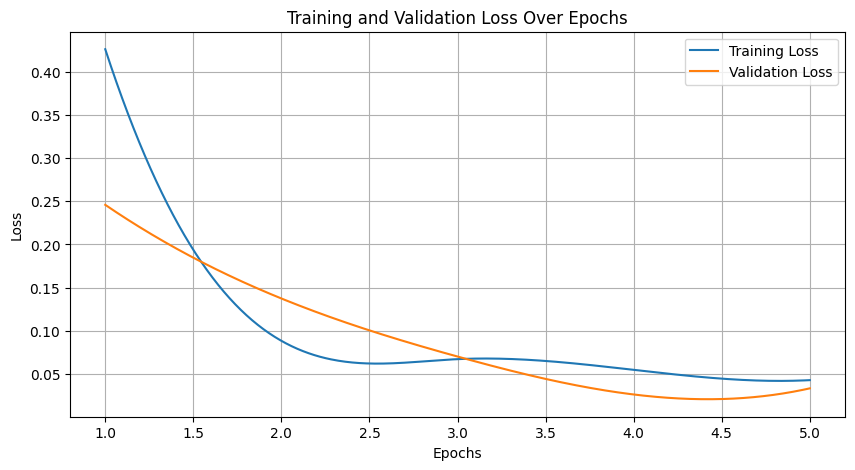

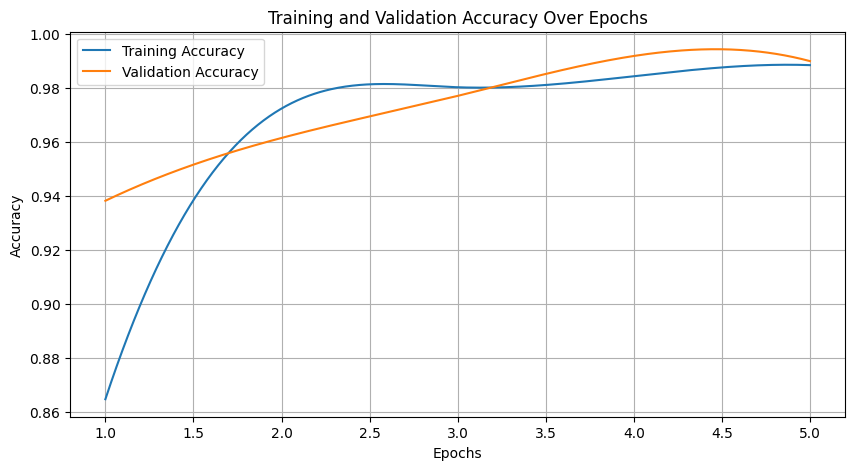

In [17]:
epochs_smooth, train_loss_smooth = smooth_data(epochs, train_loss)
_, val_loss_smooth = smooth_data(epochs, val_loss)
_, train_accuracies_smooth = smooth_data(epochs, train_accuracies)
_, val_accuracies_smooth = smooth_data(epochs, val_accuracies)

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_smooth, train_loss_smooth, label='Training Loss')
plt.plot(epochs_smooth, val_loss_smooth, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs_smooth, train_accuracies_smooth, label='Training Accuracy')
plt.plot(epochs_smooth, val_accuracies_smooth, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Confusion Matrix

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Loss: 0.0854 | Test Accuracy: 97.26%
Fine-tuned model accuracy on testing set: 0.9725670498084291


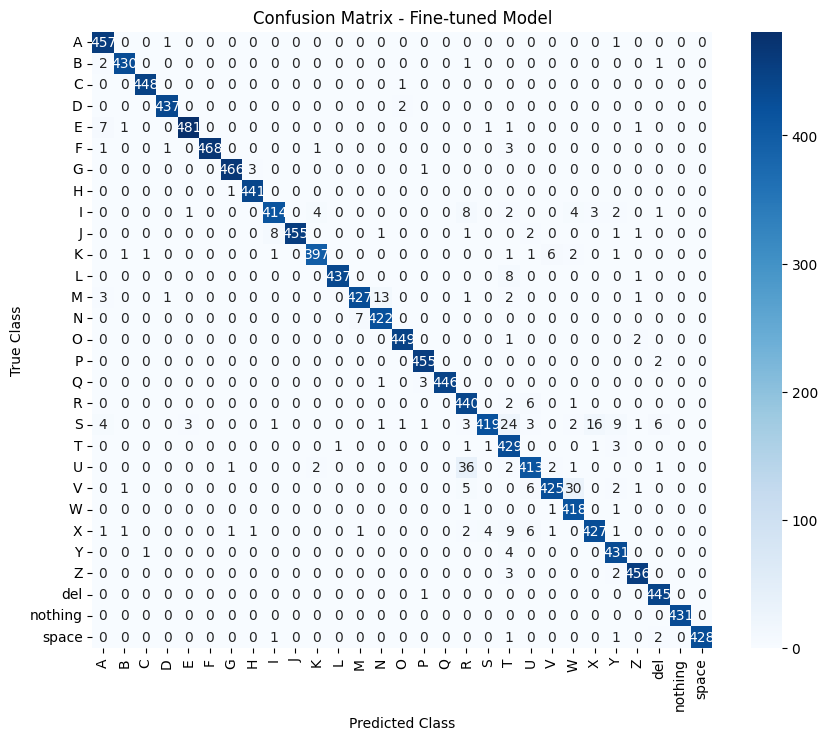

In [19]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

model.eval()
criterion = nn.CrossEntropyLoss()

# Evaluate the model
fine_tuned_predictions, fine_tuned_labels = evaluate_model(model, test_loader, criterion)

# calculate accuracy scores
fine_tuned_accuracy = accuracy_score(fine_tuned_labels, fine_tuned_predictions)

print("Fine-tuned model accuracy on testing set:", fine_tuned_accuracy)
# Generate confusion matrix
conf_matrix = confusion_matrix(fine_tuned_labels, fine_tuned_predictions)

class_names = class_names

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Fine-tuned Model")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

In [20]:
# Define a function to evaluate the model and get predicted probabilities
def get_predicted_probs_and_labels(model, data_loader):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.numpy())
    return np.concatenate(all_probs), np.concatenate(all_labels)

# Compute predicted probabilities for the fine-tuned model on the test data
predicted_probs, true_labels = get_predicted_probs_and_labels(model, test_loader)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [21]:
# Compute predicted probabilities and true labels for the standard test set
predicted_probs, true_labels = get_predicted_probs_and_labels(model, test_loader)

# Print the first 5 predictions (probabilities)
print("Predicted Probabilities (First 5):")
print(predicted_probs[:5])

# Print the first 5 true labels
print("\nTrue Labels (First 5):")
print(true_labels[:5])

# Print the top predicted class indices for the first 5 samples
predicted_classes = predicted_probs.argmax(axis=1)
print("\nPredicted Classes (First 5):")
print(predicted_classes[:5])


Predicted Probabilities (First 5):
[[1.49894940e-05 1.28820593e-05 2.77017504e-13 6.16193858e-12
  9.99721587e-01 1.26339748e-08 6.23036627e-08 1.71530132e-08
  5.89637693e-07 4.20945025e-06 1.27367386e-07 3.11702964e-12
  4.42989972e-07 2.37194236e-10 2.18813767e-07 1.94943830e-08
  1.07901856e-11 7.59828083e-07 1.71023785e-04 1.92326843e-06
  1.85697309e-06 3.08179082e-08 3.03659618e-07 6.87611173e-05
  3.02115239e-08 7.45968443e-09 1.05570858e-12 1.44506409e-13
  1.34947054e-09]
 [2.52557046e-12 3.25528798e-10 3.62414831e-09 9.99999523e-01
  3.29877002e-15 5.22369786e-11 4.54497828e-10 1.40378481e-11
  2.56530130e-10 8.84791237e-14 7.20951761e-08 1.06145182e-13
  8.11069487e-14 4.68284482e-13 1.52501886e-10 8.97823593e-10
  1.00091227e-10 3.08833449e-07 9.26327831e-16 1.56035368e-13
  9.18082832e-10 6.54608323e-09 4.73125450e-09 1.74738403e-12
  1.73223371e-14 4.80630997e-13 4.72940654e-12 1.47477088e-17
  1.27508415e-09]
 [4.28123371e-04 1.57500324e-08 7.09764976e-08 2.55706397e-07

In [22]:

# Calculate Top-1 and Top-3 Accuracy
def calculate_top_k_accuracy(pred_probs, true_labels, k=3):
    topk_preds = np.argsort(pred_probs, axis=1)[:, -k:]
    correct = np.array([true_labels[i] in topk_preds[i] for i in range(len(true_labels))])
    topk_acc = np.mean(correct)
    return topk_acc

top1_acc = calculate_top_k_accuracy(predicted_probs, true_labels, k=1)
top3_acc = calculate_top_k_accuracy(predicted_probs, true_labels, k=3)

print(f"\nTop-1 Accuracy: {top1_acc:.4f}")
print(f"Top-3 Accuracy: {top3_acc:.4f}")



Top-1 Accuracy: 0.9726
Top-3 Accuracy: 0.9972


In [23]:
from sklearn.metrics import log_loss

logloss = log_loss(true_labels, predicted_probs)
print(f"Log Loss: {logloss:.4f}")


Log Loss: 0.0854


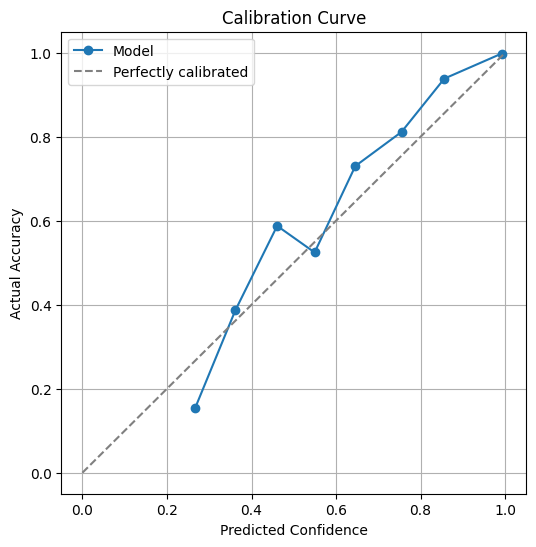

In [24]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Get predicted class and confidence
predicted_class = predicted_probs.argmax(axis=1)
confidences = predicted_probs.max(axis=1)
correct = (predicted_class == true_labels).astype(int)

# Compute calibration curve
prob_true, prob_pred = calibration_curve(correct, confidences, n_bins=10)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.title('Calibration Curve')
plt.xlabel('Predicted Confidence')
plt.ylabel('Actual Accuracy')
plt.legend()
plt.grid(True)
plt.show()


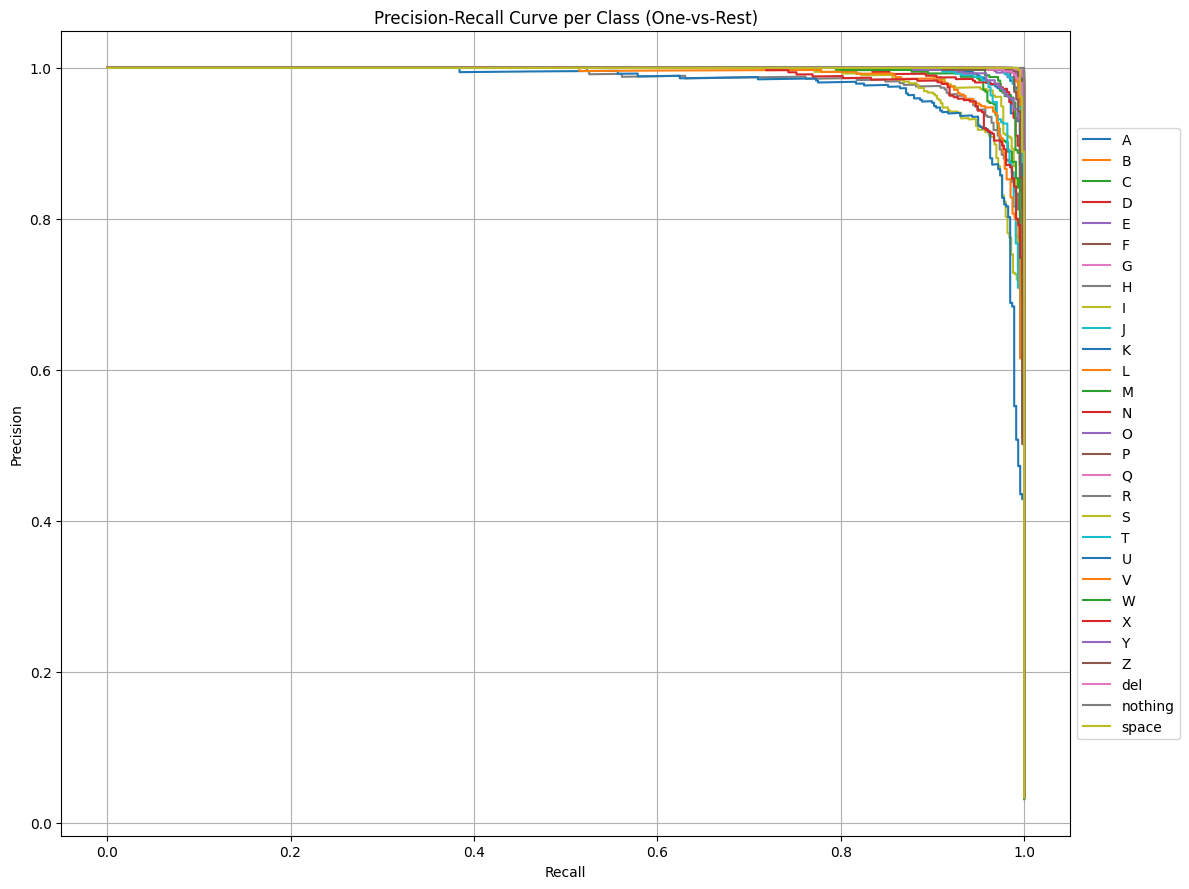

In [25]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

num_classes = len(class_names)

# One-hot encode the true labels
binarized_labels = label_binarize(fine_tuned_labels, classes=np.arange(num_classes))

# Compute precision-recall for each class
precisions = dict()
recalls = dict()

for i in range(num_classes):
    precisions[i], recalls[i], _ = precision_recall_curve(binarized_labels[:, i], predicted_probs[:, i])

# Plot PR curves
plt.figure(figsize=(12, 9))
for i in range(num_classes):
    plt.plot(recalls[i], precisions[i], label=class_names[i])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve per Class (One-vs-Rest)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
!pip install torchsummary

In [27]:
from torchsummary import summary

your_model = model.to(device)       # move model to CPU or GPU
input_size = (3, 224, 224)          # RGB image size for MobileNetV2
summary(your_model, input_size)     # print model summary


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [28]:
import os

test_dir = "asl_alphabet/asl_alphabet_test"
for root, dirs, files in os.walk(test_dir):
    print("DIR:", root)
    print("Subdirs:", dirs)
    print("Files:", files)
    print("-" * 40)


DIR: asl_alphabet/asl_alphabet_test
Subdirs: ['asl_alphabet_test']
Files: []
----------------------------------------
DIR: asl_alphabet/asl_alphabet_test/asl_alphabet_test
Subdirs: []
Files: ['L_test.jpg', 'D_test.jpg', 'space_test.jpg', 'E_test.jpg', 'Y_test.jpg', 'F_test.jpg', 'Z_test.jpg', 'J_test.jpg', 'M_test.jpg', 'T_test.jpg', 'W_test.jpg', 'I_test.jpg', 'nothing_test.jpg', 'O_test.jpg', 'X_test.jpg', 'U_test.jpg', 'N_test.jpg', 'Q_test.jpg', 'K_test.jpg', 'V_test.jpg', 'G_test.jpg', 'B_test.jpg', 'H_test.jpg', 'A_test.jpg', 'P_test.jpg', 'S_test.jpg', 'C_test.jpg', 'R_test.jpg']
----------------------------------------


In [67]:
import os
import shutil

# Source directory
flat_test_dir = "asl_alphabet/asl_alphabet_test/asl_alphabet_test"
structured_test_dir = "asl_alphabet/structured_test"

# Create the structured test directory
os.makedirs(structured_test_dir, exist_ok=True)

# Iterate through test images and move to corresponding class folders
for filename in os.listdir(flat_test_dir):
    if filename.endswith(".jpg"):
        # Extract class label from filename
        class_label = filename.split("_")[0]
        class_label = class_label.capitalize()  # Ensure consistency with training set

        # Ensure consistency for special classes
        if class_label == "Del":
            class_label = "del"
        elif class_label == "Nothing":
            class_label = "nothing"
        elif class_label == "Space":
            class_label = "space"

        # Create the class folder if it doesn't exist
        class_dir = os.path.join(structured_test_dir, class_label)
        os.makedirs(class_dir, exist_ok=True)

        # Move the file to the appropriate class folder
        src_path = os.path.join(flat_test_dir, filename)
        dst_path = os.path.join(class_dir, filename)
        shutil.copy(src_path, dst_path)  # Using copy instead of move for testing


In [68]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Apply the same transformations as the training set
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize the structured test dataset
actual_test_dataset = datasets.ImageFolder(root="asl_alphabet/structured_test", transform=transform)

# Verify the class-to-index mapping
print("\nClass-to-Index Mapping (Test Set):")
print(actual_test_dataset.class_to_idx)

# Recreate the DataLoader
actual_test_loader = DataLoader(actual_test_dataset, batch_size=32, shuffle=False)



Class-to-Index Mapping (Test Set):
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'Nothing': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'Space': 20, 'T': 21, 'U': 22, 'V': 23, 'W': 24, 'X': 25, 'Y': 26, 'Z': 27, 'nothing': 28, 'space': 29}


In [70]:
# Print class names in the foreign dataset
print("Foreign Dataset Classes:", actual_test_loader.dataset.classes)

Foreign Dataset Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'Nothing', 'O', 'P', 'Q', 'R', 'S', 'Space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'nothing', 'space']


In [72]:
# Define the correct class order
correct_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
                 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
                 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

# Create the new label mapping
label_mapping = {label: i for i, label in enumerate(correct_order)}

# Apply the new label mapping explicitly to each sample
mapped_samples = []
for path, label in actual_test_dataset.samples:
    class_name = os.path.basename(os.path.dirname(path))  # Extract class name from path
    if class_name in label_mapping:
        mapped_samples.append((path, label_mapping[class_name]))
    else:
        print(f"Warning: Class '{class_name}' not found in label mapping.")

# Update the samples with the new mapped labels
actual_test_dataset.samples = mapped_samples

# Update the class indices and classes
actual_test_dataset.class_to_idx = label_mapping
actual_test_dataset.classes = correct_order

# Recreate the DataLoader
actual_test_loader = DataLoader(actual_test_dataset, batch_size=32, shuffle=False)

print("\nUpdated Foreign Dataset Class Order with Explicit Re-Mapping:")
print(actual_test_loader.dataset.classes)



Updated Foreign Dataset Class Order with Explicit Re-Mapping:
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']



Evaluating on Foreign Dataset:
Test Loss: 0.0087 | Test Accuracy: 100.00%


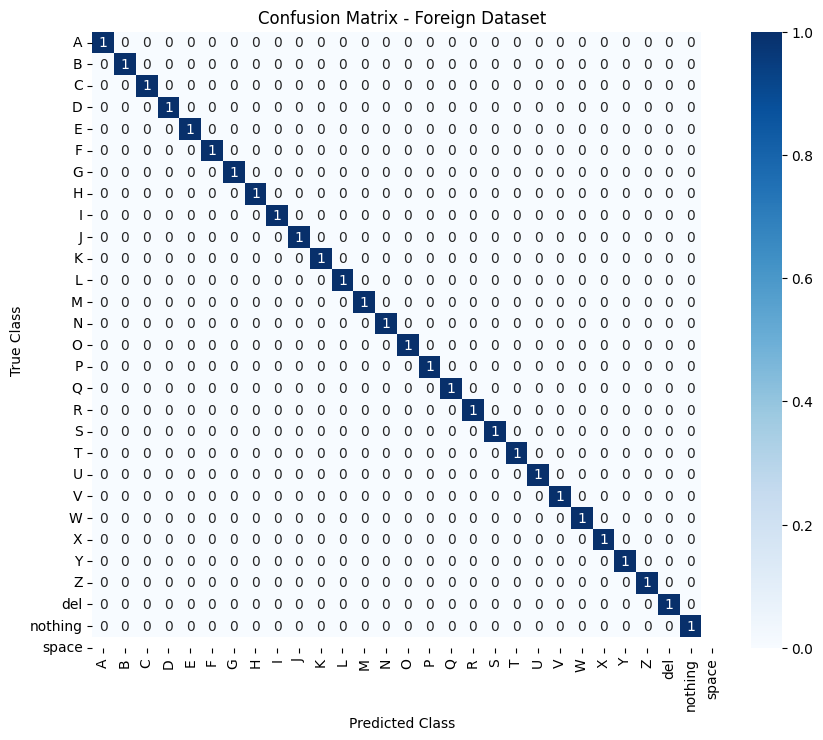

In [73]:
print("\nEvaluating on Foreign Dataset:")
foreign_preds, foreign_labels = evaluate_model(model, actual_test_loader, criterion)

# Generate and plot confusion matrix
conf_matrix = confusion_matrix(foreign_labels, foreign_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Foreign Dataset")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()
